# Response of a First Order System to Step and Square Wave Inputs

Keywords: Simulator, ipopt usage

```{index} Simulator
```
```{index} ipopt
```

This notebook demonstrates simulation of a linear first-order system in Pyomo using the `Simulator` class from Pyomo.  The notebook also demonstrates the construction and use of analytical approximations to step functions and square wave inputs.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from math import pi

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
    else:
        try:
            !conda install -c conda-forge ipopt 
        except:
            pass

assert(shutil.which("ipopt") or os.path.isfile("ipopt"))
    
from pyomo.environ import *
from pyomo.dae import *

## First-order differential equation with constant input

The following cell simulates the response of a first-order linear model in the form

$$
\begin{align}
\tau\frac{dy}{dt} + y & = K u(t) \\
\end{align}
$$

where $\tau$ and $K$ are model parameters, and $u(t)=1$ is an external process input.  

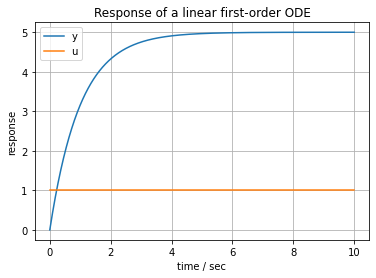

In [2]:
tfinal = 10
tau = 1
K = 5

# define u(t)
u = lambda t: 1

# create a model object
model = ConcreteModel()

# define the independent variable
model.t = ContinuousSet(bounds=(0, tfinal))

# define the dependent variables
model.y = Var(model.t)
model.dydt = DerivativeVar(model.y)

# fix the initial value of y
model.y[0].fix(0)

# define the differential equation as a constraint
model.ode = Constraint(model.t, rule=lambda model, t: tau*model.dydt[t] + model.y[t] == K*u(t))

# simulation using scipy integrators
tsim, profiles = Simulator(model, package='scipy').simulate(numpoints=1000)

fig, ax = plt.subplots(1, 1)
ax.plot(tsim, profiles, label='y')
ax.plot(tsim, [u(t) for t in tsim], label='u')
ax.set_xlabel('time / sec')
ax.set_ylabel('response')
ax.set_title('Response of a linear first-order ODE')
ax.legend()
ax.grid(True)

## Encapsulating into a function

In following cells we would like to explore the response of a first order system to changes in parameters and input functions. To facilitate this study, the next cell encapsulates the simulation into a function that can be called with different parameter values and input functions.

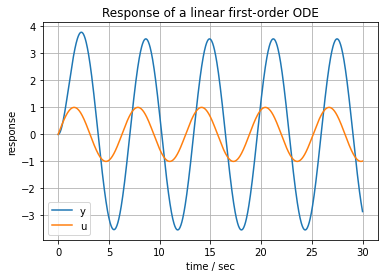

In [3]:
def first_order(K=1, tau=1, tfinal=1, u=lambda t: 1):
    model = ConcreteModel()
    model.t = ContinuousSet(bounds=(0, tfinal))
    model.y = Var(model.t)
    model.dydt = DerivativeVar(model.y)
    model.y[0].fix(0)
    model.ode = Constraint(model.t, rule=lambda model, t: 
                           tau*model.dydt[t] + model.y[t] == K*u(t))
    
    tsim, profiles = Simulator(model, package='scipy').simulate(numpoints=1000)

    fig, ax = plt.subplots(1, 1)
    ax.plot(tsim, profiles, label='y')
    ax.plot(tsim, [u(t) for t in tsim], label='u')
    ax.set_xlabel('time / sec')
    ax.set_ylabel('response')
    ax.set_title('Response of a linear first-order ODE')
    ax.legend()
    ax.grid(True)
    
first_order(5, 1, 30, sin)

## Analytical approximation to a step input
Keywords: step input

The response to a step change is a common test giving insight into the dynamics of a given system. An infinitely differentiable approximation to a step change is given by the *Butterworth function* $b_n(t)$

$$ b_n(t) = \frac{1}{1 + (\frac{t}{c})^n} $$

where $n$ is the order of a approximation, and $c$ is value of $t$ where the step change occurs.

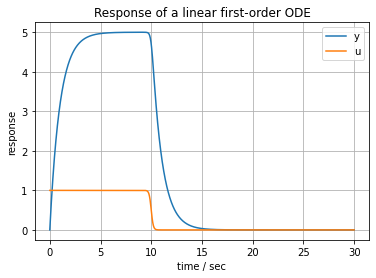

In [4]:
u = lambda t: 1/(1 + (t/10)**100)

first_order(5, 1, 30, u)

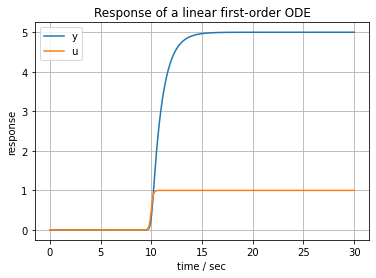

In [5]:
u = lambda t: 1 - 1/(1 + (t/10)**100)

first_order(5, 1, 30, u)

## Analytical approximation to a square wave input
Keywords: square wave input

An analytical approximation to a square wave with frequency $f$ is given by

$$\frac{4}{\pi} \sum_{k=1, 3, 5,\ldots}^N \frac{sin(k\pi/N)}{k\pi/N}\frac{sin(2\pi ft)}{k}$$

where the first term is the *Lanczos* sigma factor designed to suppress the Gibb's phenomenon associated with Fourier series approximations.

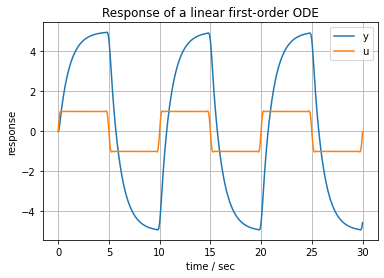

In [6]:
def square(t, f=1, N=31):
    return (4/pi)*sum((N*sin(k*pi/N)/k/pi)*sin(2*k*f*pi*t)/k for k in range(1, N+1,2))
  
u = lambda t: square(t, 0.1)

first_order(5, 1, 30, u)